In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns

import plotly
import plotly.express as px
import category_encoders as ce # импорт для работы с кодировщиком
import matplotlib.pyplot as plt

import re
import statistics

from sklearn import preprocessing

import category_encoders as ce # импорт для работы с кодировщиком

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Постановка задачи

Модель должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. В датасете содержатся сведения о 515 000 отзывов на отели Европы.

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [6]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [7]:
# Подгрузка данных 

data_dir = './data/sf-booking'
test_dir = 'hotels_test.csv'
train_dir = 'hotels_train.csv'
subm_dir = 'submission.csv'

df_train = pd.read_csv(os.path.join(data_dir, train_dir)) # датасет для обучения
df_test = pd.read_csv(os.path.join(data_dir, test_dir)) # датасет для предсказания
df_submission = pd.read_csv(os.path.join(data_dir, subm_dir)) # submission

## Первичный анализ датасетов

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [9]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Есть пропуски в признаках lat и lng

In [11]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [12]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [13]:
df_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


### Проверка на наличие дубликатов

In [14]:
df_train.duplicated().sum()

307

Обнаружено 307 дубликатов

In [15]:
# Удалим дубликаты
df_train = df_train.drop_duplicates()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 10  r

In [16]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем, где у нас трейн
df_test['sample'] = 0 # помечаем, где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по-этому пока просто заполняем нулями

hotels = pd.concat([df_test, df_train], ignore_index=True).reset_index(drop=True) # объединяем

In [17]:
# Статистика для числовых признаков
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,512163.000000,512163.000000,515431.00000,515431.000000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,49.442788,2.824057,0.74985,6.296715
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,3.467323,4.580730,0.43310,3.902967
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.00000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214277,-0.143372,0.00000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,-0.000250,1.00000,7.900000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,51.516288,4.834443,1.00000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.00000,10.000000


In [18]:
# Статистика для признаков типа 'object'
hotels.describe(include=['object'])

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515431,515431,515431,515431,515431,515431,515431,515431
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2584,4789,245165,127816,35924,5101,2584


<Axes: >

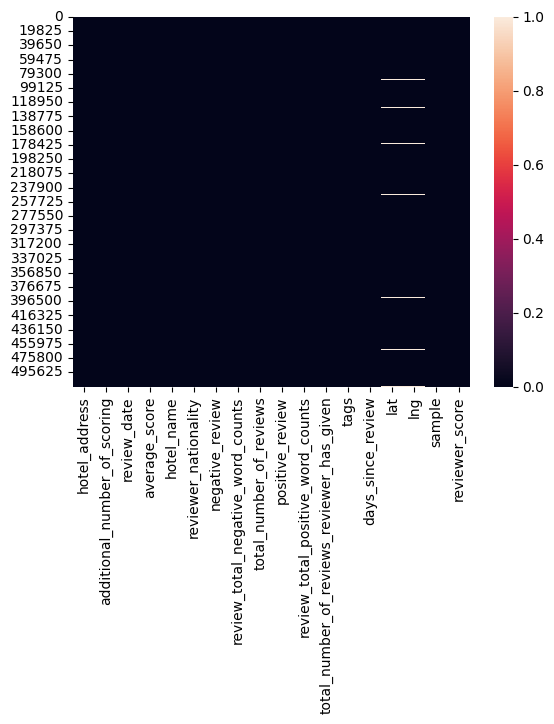

In [19]:
# Визуализация пропусков
sns.heatmap(hotels.isnull())

Анализ показал:
1. В датасете содержится информация о 1493 уникальных отелях
2. Пропуски найдены в признаках lat и long
3. В датасете есть 10 числовых столбцов, остальные 8 представлены типом данных object
4. Минимальная оценка отеля 0, максимальная 10, средняя 6.3

## Очистка данных, устранение пропусков

In [20]:
# выведем строки, в которых значения lat и lng пустые
hotels_null = hotels[hotels['lat'].isnull()]
adress_null=list(hotels_null['hotel_address'].unique())


In [21]:
coordinates_hotels = {
 '20 Rue De La Ga t 14th arr 75014 Paris France': [48.838331, 2.330948],
 '23 Rue Damr mont 18th arr 75018 Paris France': [48.856663, 2.351556],
 '4 rue de la P pini re 8th arr 75008 Paris France': [48.856663, 2.351556],
 'Bail n 4 6 Eixample 08010 Barcelona Spain': [41.396133, 1.655829],
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': [48.222139, 16.357513],
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': [48.778035, 15.65565],
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': [48.210918, 16.347119],
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': [48.210918, 16.347119],
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': [48.206487, 16.36346],
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': [48.176599, 16.413999],
 'Pau Clar s 122 Eixample 08009 Barcelona Spain': [41.504994, 2.245959],
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': [48.211783, 16.297308],
 'Sep lveda 180 Eixample 08011 Barcelona Spain': [41.425226, 2.181864],
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': [48.245935, 16.341397],
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': [48.218213, 16.39411],
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': [48.222139,16.357513],
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': [48.222139, 16.357513]
}

In [22]:
# Заполним отсутствующие координаты отелей
for address in adress_null:
    hotels.loc[(hotels['lat'].isnull()) | (hotels['lng'].isnull()) & (hotels['hotel_address'] == address), 'lat'] = coordinates_hotels[address][0]
    hotels.loc[(hotels['lat'].isnull()) | (hotels['lng'].isnull()) & (hotels['hotel_address'] == address), 'lng'] = coordinates_hotels[address][1]

In [23]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Пропусков в lat и lng больше нет

Построим матрицу корреляции

<Axes: >

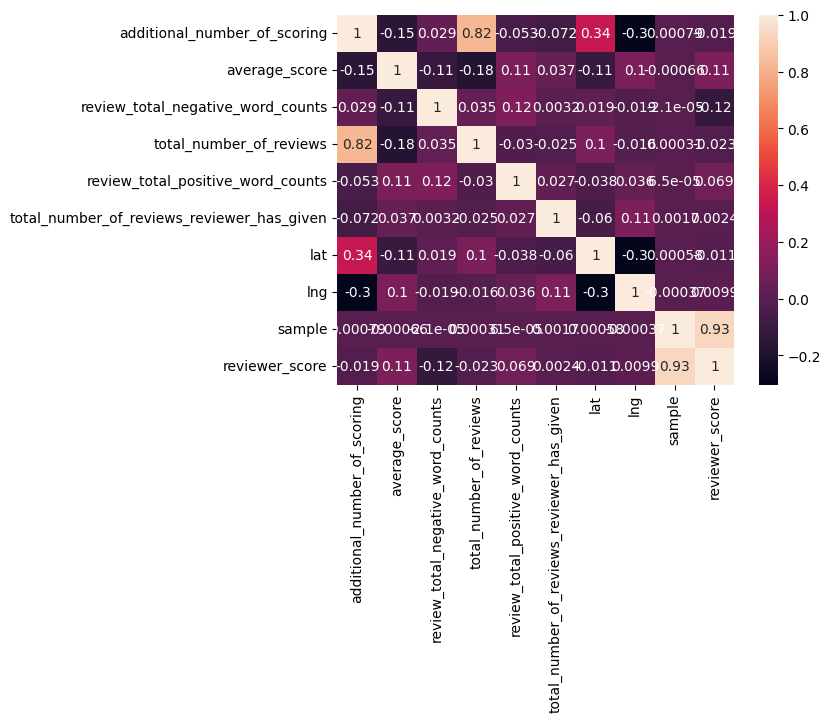

In [24]:
# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(hotels.corr(numeric_only=True), annot=True)

Удаляем признак с высокой корреляцией

In [25]:
hotels = hotels.drop(columns=['total_number_of_reviews'], axis=1)

In [26]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

## Создание новых признаков

### hotel_address

In [27]:
# создадим новый признак city
hotels['city'] = hotels['hotel_address'].apply(lambda x : 'London' if x.split()[-1] == 'Kingdom' else x.split()[-2])

# создадим новый признак country
hotels['country'] = hotels['hotel_address'].apply(lambda x : 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

Закодируем столбцы city и country. С учетом количества элементов используем OneHotEncoder 

In [28]:
encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True) # указываем столбец для кодирования
type_city = encoder.fit_transform(hotels['city'])
hotels = pd.concat([hotels, type_city], axis=1)

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) # указываем столбец для кодирования
type_country = encoder.fit_transform(hotels['country'])
hotels = pd.concat([hotels, type_country], axis=1)

In [29]:
# Удаляем столбец "hotel_address"
hotels = hotels.drop(['hotel_address', 'city','country'],axis=1)

### review_date

In [30]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

In [31]:
hotels['year'] = hotels['review_date'].dt.year
hotels['day'] = hotels['review_date'].dt.day
hotels['month'] = hotels['review_date'].dt.month

In [32]:
#считаем количество записей в зависимости от года
bar_data = hotels.groupby(
    by='year',
    as_index=False
)[['year']].value_counts()
  
#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x="year", #ось x
    y="count", #ось y
    labels = {'year': 'Год отзыва', 'count': 'Количество записей'},
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Диаграмма Количества записей в зависимости года' #заголовок
)

#отображаем его
fig.show()

Данные представлены за 3 года 2015-2017

In [33]:
#считаем количество записей в зависимости от года
bar_data = hotels.groupby(
    by='month',
    as_index=False
)[['month']].value_counts()
  
#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x="month", #ось x
    y="count", #ось y
    labels = {'review_year': 'Месяц отзыва', 'count': 'Количество записей'},
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Диаграмма Количества записей в зависимости месяца' #заголовок
)

#отображаем его
fig.show()

In [34]:
hotels = hotels.drop(['review_date'],axis=1)

### tags

Из тега оставим информацию о количестве ночей

In [35]:
hotels['tags_night'] = hotels['tags'].apply(lambda x: re.findall(r'\w+ \d+ night', x)[0] if len(re.findall(r'\w+ \d+ night', x))>0 else '0')
hotels['tags_night_num'] = hotels['tags_night'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

#считаем количество записей в зависимости от должности
treemap_data = hotels.groupby(
    by='tags_night_num'
)['tags_night_num'].count()
treemap_data = treemap_data.to_frame(name='count').reset_index()

#строим график
fig = px.treemap(
    data_frame=treemap_data, #датафрейм
    path=['tags_night_num'], #кат. признак, для которого строится график
    values='count', #параметр, который сравнивается
    height=500, #высота
    width=700, #ширина
    title='Диаграмма Количества записей с тегом количества ночей ' #заголовок
)

#отображаем его
fig.show()

Большинство отзывов в данных оставлены с тегом количества ночей = 1

In [36]:
hotels['tags_night_num'].value_counts()

tags_night_num
1     193567
2     133849
3      95765
4      47777
5      20824
6       9765
7       7391
8       2499
9       1293
10       888
11       417
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
27        11
30        11
23        10
22        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: count, dtype: int64

In [37]:
# Заполним пропуски в данных средним значением и преобразуем его в число
def replacing_passes(night):
    if night == 0:
        return (hotels['tags_night_num'].mean())
    else:
        return night
    
hotels['tags_night_num'] = hotels['tags_night_num'].apply(replacing_passes).astype('int')

In [38]:
hotels = hotels.drop(['tags', 'tags_night'],axis=1)

### days_since_review

In [39]:
hotels['days_since_review_num'] = hotels['days_since_review'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
hotels['days_since_review_num'].value_counts()

days_since_review_num
1      2584
322    2304
120    2284
338    1959
534    1939
       ... 
327     199
615     194
122     192
124     173
123     142
Name: count, Length: 731, dtype: int64

In [40]:
hotels = hotels.drop(['days_since_review'],axis=1)

### hotel_name

In [41]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [42]:
hotels = hotels.drop(['hotel_name'],axis=1)

### reviewer_nationality

In [43]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [44]:
hotels = hotels.drop(['reviewer_nationality'],axis=1)

In [45]:
hotels = hotels.drop(['negative_review', 'positive_review'],axis=1)

In [46]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   lat                                         515431 non-null  float64
 6   lng                                         515431 non-null  float64
 7   sample                                      515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   city_Milan                                  515431 non-null  int64  
 

## Отбор признаков


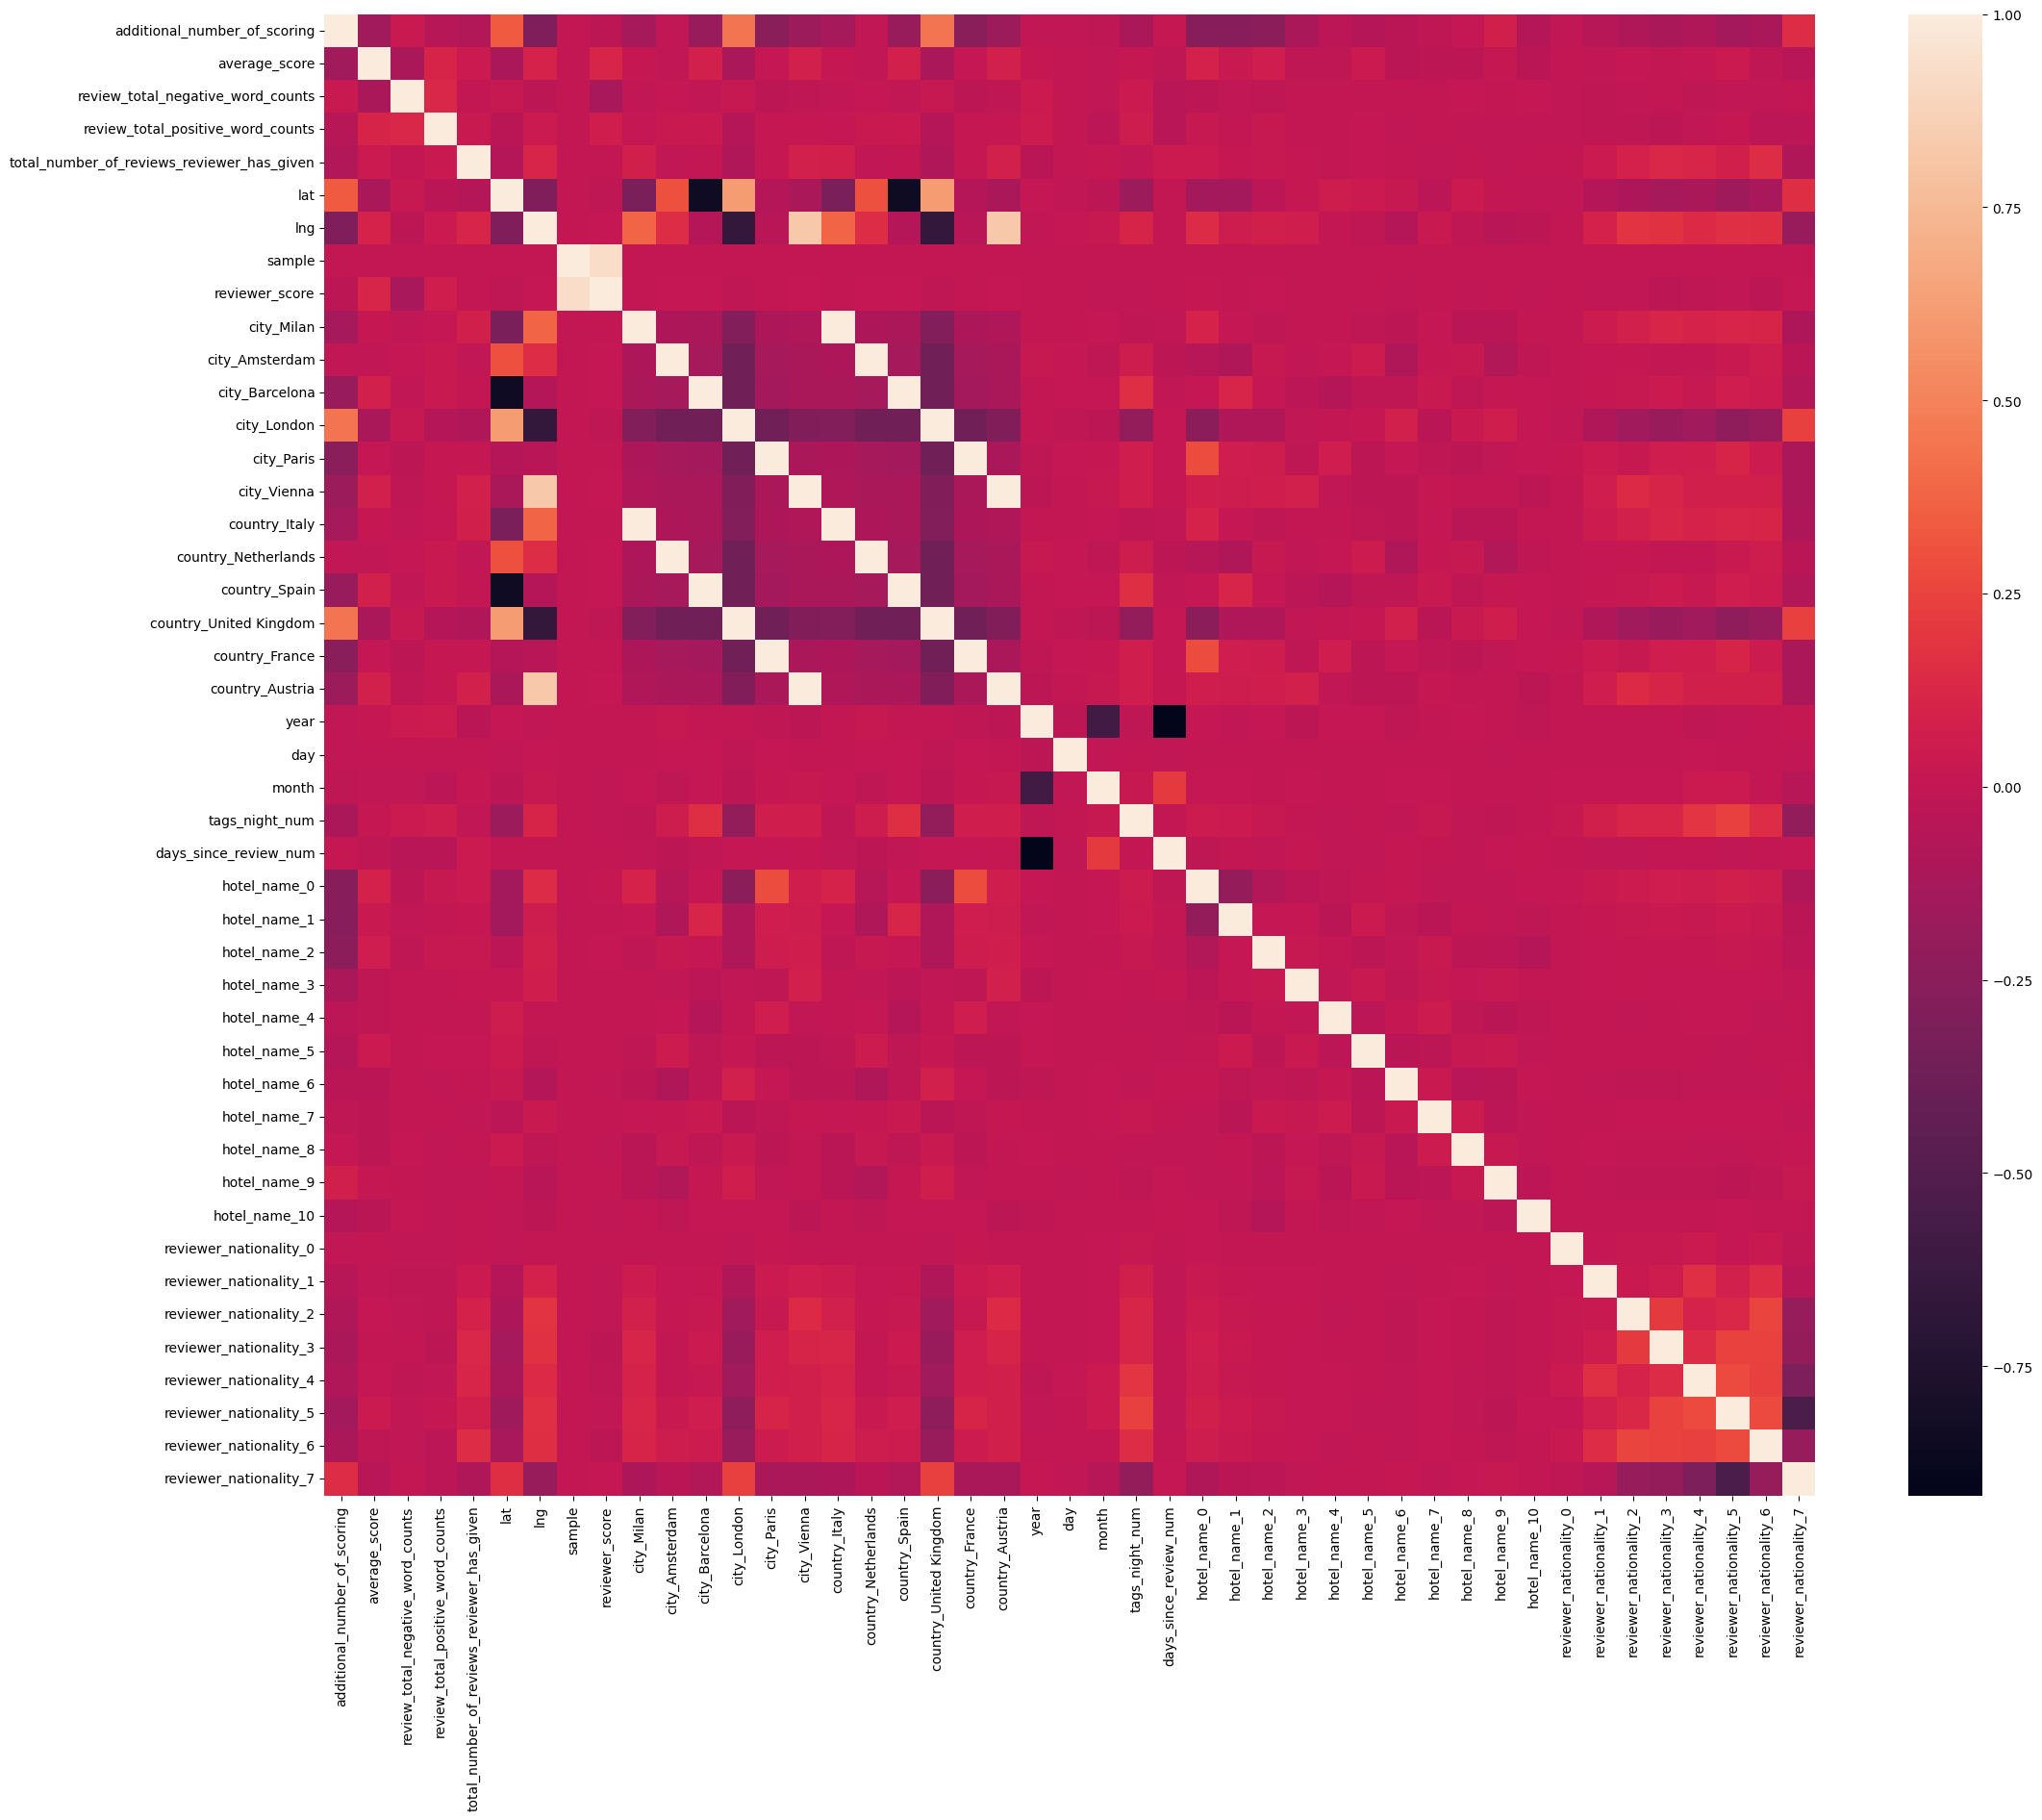

In [47]:
fig_, ax_ = plt.subplots(figsize=(25, 20))
sns.heatmap(hotels.corr(numeric_only=True))

plt.show()



Удаляем признаки с сильной корреляцией

In [48]:
hotels = hotels.drop(['city_Milan', 'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Paris', 'city_Vienna', 'country_Austria'],axis=1)

Произведём оценку значимости каждого признака для целевой переменной - рейтинг отеля. Используем для этого тесты хи-квадрат и ANOVA.

In [49]:
y = hotels['reviewer_score'] 
X = hotels.drop(['reviewer_score'], axis = 1)  

In [50]:
# Разделим признаки на непрерывные и категориальные

# Непрерывные признаки
num_cols = [
 'additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',

]


# Категориальные признаки
cat_cols = [
'country_Italy',
'country_Netherlands',
'country_Spain',
'country_United Kingdom',
'country_France',
'tags_night_num',
'days_since_review_num',
'month',
'year',
'day',
'hotel_name_0',
'hotel_name_1',
'hotel_name_2',
'hotel_name_3',
'hotel_name_4',
'hotel_name_5',
'hotel_name_6',
'hotel_name_7',
'hotel_name_8',
'hotel_name_9',
'hotel_name_10',
'reviewer_nationality_0',
'reviewer_nationality_1',
'reviewer_nationality_2',
'reviewer_nationality_3',
'reviewer_nationality_4',
'reviewer_nationality_5',
'reviewer_nationality_6',
'reviewer_nationality_7',

]

<Axes: >

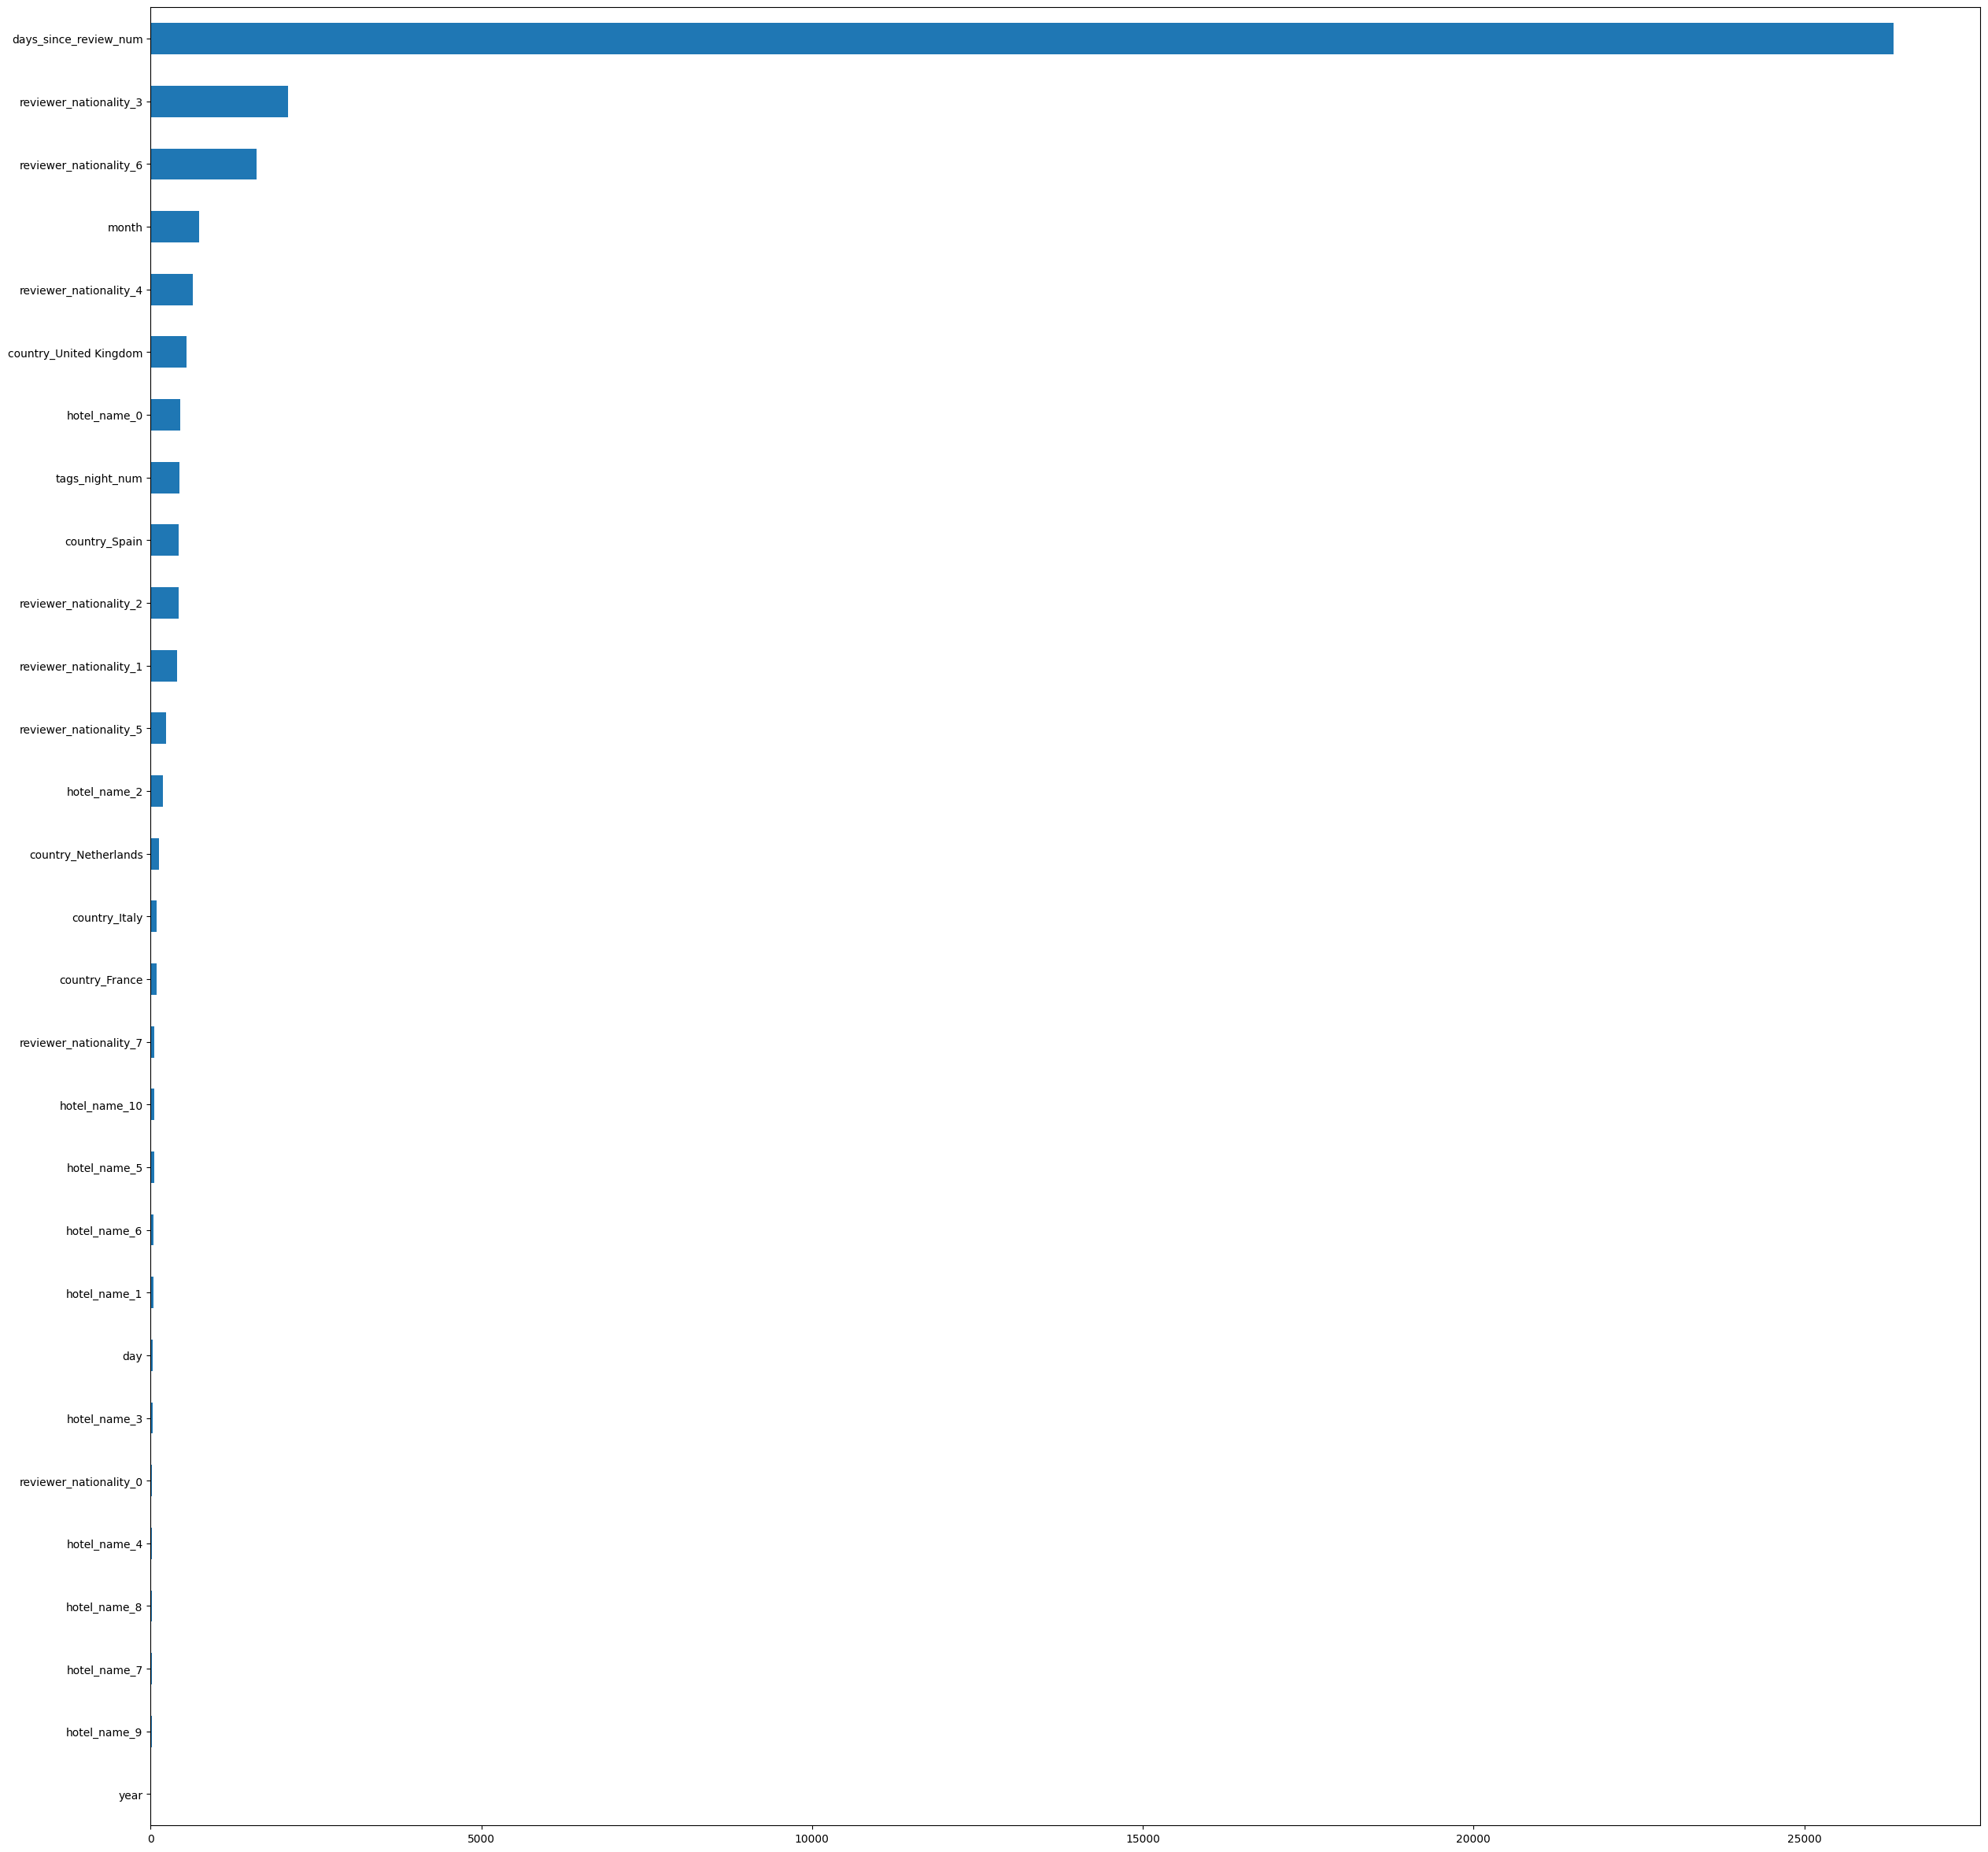

In [51]:
y=y.astype('int')


imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(30, 30))

<Axes: >

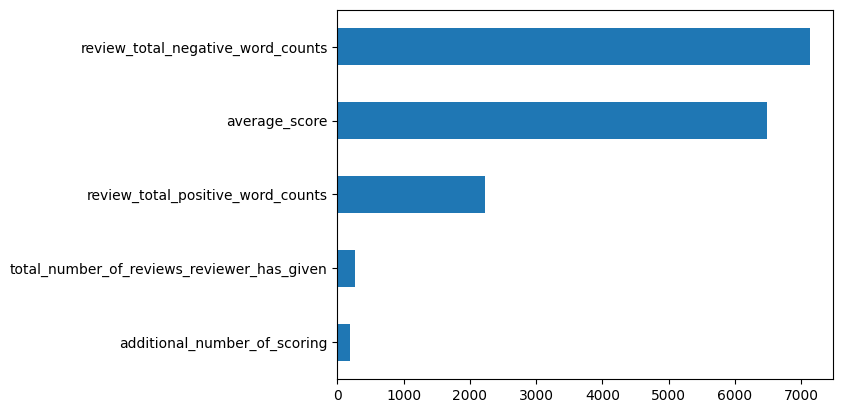

In [52]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Обучение модели

In [53]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [54]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [55]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

In [56]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [57]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13587628414112032


1. MAPE: 0.1359106012760551

2. MAPE: 0.13579141102103082

<Axes: >

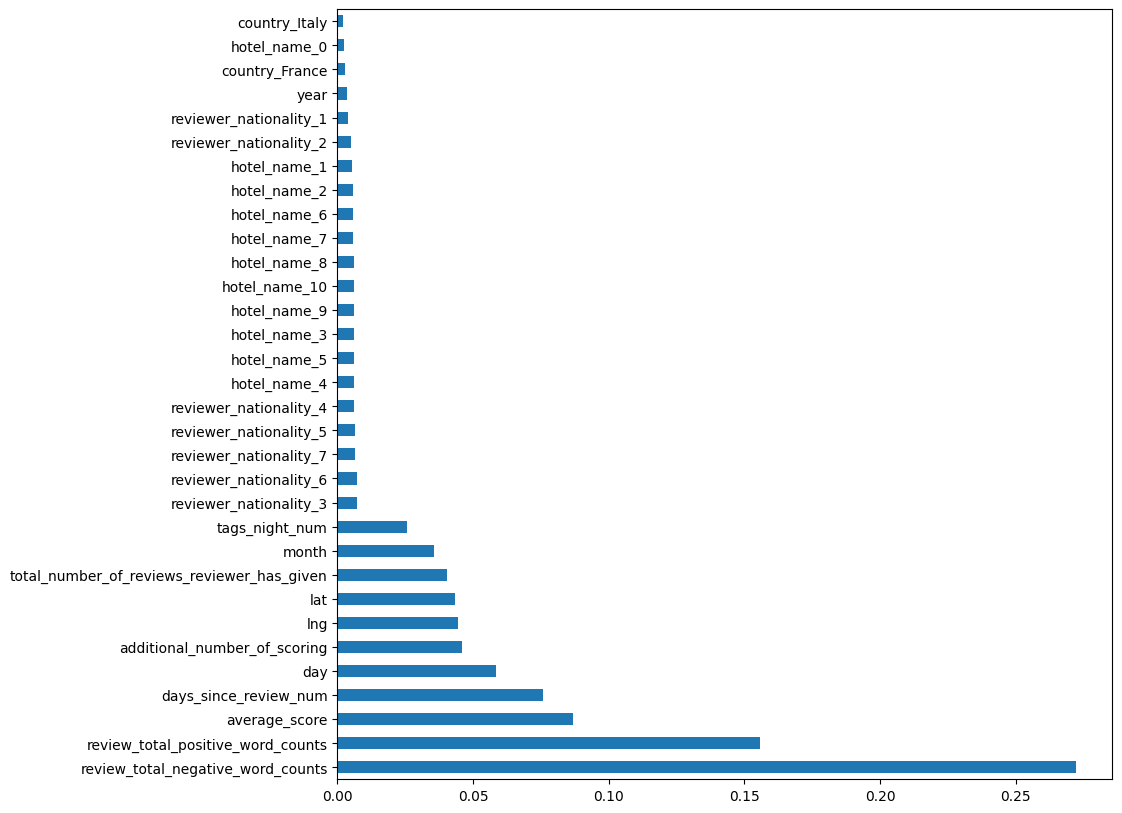

In [58]:
# В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(32).plot(kind='barh')

In [59]:
test_data.sample(10)


,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,country_Italy,country_Netherlands,...,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
30596,333,8.3,0,6,9,48.210918,16.347119,0.0,0,0,...,0,1,0,0,0,1,1,1,0,0
4692,333,8.0,0,7,7,48.854864,2.292318,0.0,0,0,...,1,0,0,1,1,1,0,0,0,0
5776,461,9.2,10,5,4,51.521807,-0.085608,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
118186,20,7.0,17,14,2,48.836420,2.360333,0.0,0,0,...,1,0,0,0,0,1,1,1,0,0
84378,398,8.7,2,7,1,45.463068,9.197937,0.0,1,0,...,1,0,0,0,1,1,0,0,0,0
126647,704,8.8,14,0,1,51.520815,-0.091532,0.0,0,0,...,0,1,0,0,0,0,0,0,0,1
60698,468,7.7,14,3,4,51.524145,-0.160991,0.0,0,0,...,0,1,0,0,0,0,0,0,0,1
124588,184,7.9,13,4,5,41.383012,2.170070,0.0,0,0,...,1,1,0,0,1,0,0,0,0,0
3938,681,8.9,2,54,8,51.516099,-0.118175,0.0,0,0,...,1,1,0,0,0,0,0,0,0,1
93470,183,8.5,16,6,6,48.874389,2.298091,0.0,0,0,...,0,1,0,0,1,0,1,1,0,0


In [60]:
# Удаляем целевой признак из выборки
test_data = test_data.drop(['reviewer_score'], axis=1)


In [61]:
test_data

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,country_Italy,country_Netherlands,country_Spain,...,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,904,8.1,52,62,1,45.533137,9.171102,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,612,8.6,10,0,7,52.385649,4.834443,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,46,8.3,3,5,15,41.393192,2.161520,0,0,1,...,1,1,0,0,0,0,0,0,1,1
3,241,9.1,0,27,9,45.479888,9.196298,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,834,9.1,0,7,2,52.370545,4.888644,0,1,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128930,53,8.1,0,4,14,45.502453,9.221836,1,0,0,...,0,0,0,0,0,1,0,1,0,1
128931,46,7.8,0,24,1,41.378169,2.178663,0,0,1,...,0,1,0,0,0,0,0,1,0,0
128932,260,8.0,31,23,1,48.193523,16.366915,0,0,0,...,1,0,0,1,0,0,1,0,1,0
128933,159,9.0,0,20,7,45.468236,9.207380,1,0,0,...,0,1,0,0,0,0,1,1,0,0


In [62]:
# Сохраняем предсказание модели
df_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [63]:
predict_submission = regr.predict(test_data)

In [64]:
predict_submission

array([8.897, 6.882, 8.352, ..., 8.206, 9.577, 7.253])

In [66]:
df_submission['reviewer_score'] = predict_submission
df_submission.to_csv('./submission.csv', index=False)
df_submission.head(10)

,reviewer_score,id
0,8.897,488440
1,6.882,274649
2,8.352,374688
3,9.542,404352
4,9.791,451596
5,8.831,302161
6,8.279,317079
7,7.886,13963
8,8.730,159785
9,7.752,195089
